# Imports

In [116]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix

import numpy as np
import matplotlib.pyplot as plt

ERROR! Session/line number was not unique in database. History logging moved to new session 61


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Training and testset

In [ ]:
# Definerer batch size, antall klasser, learning rate og antall epoker for klassifiseringen.
BATCH_SIZE = 30
NUM_CLASSES = 10
learning_rate = 0.001
num_epochs = 10

## transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

# Laster inn training og test set til Fashion MNIST fra Torchvision.
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)


testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

# The classifier

In [ ]:
class NnDigitsClassifier(nn.Module):
    def __init__(self):
        super(NnDigitsClassifier, self).__init__()

        # Task 1: Implementing layers for classification. Uses sequential layering to gather conv-layer and pooling-layer in one.
        # The first layer.
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        # The second layer.
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        # The third layer.
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.drop_out = nn.Dropout(0.1)
        self.fc1 = nn.Linear(3 * 3 * 128, 100)
        self.fc2 = nn.Linear(100, NUM_CLASSES)

        
    # Defines the function "forward" which sends the information through the different layers.
    def forward(self, x):
      out = self.layer1(x)
      out = self.layer2(out)
      out = self.layer3(out)

      out = out.reshape(out.size(0), -1)

      out = self.drop_out(out)
      out = self.fc1(out)
      out = self.fc2(out)
      return out

In [ ]:
# Tells the program to use the GPU if available, if not, use the CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Defines the object model
model = NnDigitsClassifier()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training

In [140]:
# Task 2: Training the network
loss_list = []
acc_list = []
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(trainloader):

    # Runs the forward method.
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss_list.append(loss.item())

    # Runs the Adam optimization.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    # Tracks the accuracy.
    total = labels.size(0)
    _, x_predicted = torch.max(outputs.data, 1)
    correct = (x_predicted == labels).sum().item()
    acc_list.append(correct / total)
  

  print('Epoch [{}/{}] | Loss: {:.4f} | Accuracy: {:.2f}%'.format(epoch +1, num_epochs, loss.item(), (correct /total) * 100))


Epoch [1/10] | Loss: 0.3487 | Accuracy: 83.33%
Epoch [2/10] | Loss: 0.3735 | Accuracy: 86.67%
Epoch [3/10] | Loss: 0.0670 | Accuracy: 100.00%
Epoch [4/10] | Loss: 0.2429 | Accuracy: 90.00%
Epoch [5/10] | Loss: 0.2132 | Accuracy: 90.00%
Epoch [6/10] | Loss: 0.0936 | Accuracy: 96.67%
Epoch [7/10] | Loss: 0.0792 | Accuracy: 96.67%
Epoch [8/10] | Loss: 0.1601 | Accuracy: 90.00%
Epoch [9/10] | Loss: 0.0772 | Accuracy: 96.67%
Epoch [10/10] | Loss: 0.0478 | Accuracy: 100.00%


# Saving and loading

In [108]:
torch.save(model, 'drive/My Drive/INFO284/model.pt')
torch.save(model.state_dict(), 'drive/My Drive/INFO284/model_state_dict.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type NnDigitsClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
full_model = torch.load('drive/My Drive/INFO284/model.pt')
model_state_dict = torch.load('drive/My Drive/INFO284/model_state_dict.pt')

In [ ]:
print(full_model)

In [ ]:
print(model_state_dict)

# Confusion Matrix

In [ ]:
@torch.no_grad()
def get_all_prediction(model, loader):
    preds = torch.tensor([])
    for batch in loader:
        images, labels = batch
        batch_predictions = model(images)
        preds = torch.cat((preds, batch_predictions), dim = 0)
    return preds

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    # Kalkulere confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Unødvendig kode for representasjon i figure form.
    # Dette er bare for at den skal sjå pen ut hehe.
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
train_preds = get_all_prediction(model, testloader)

In [ ]:
label_dict = {
 'T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot',
}

In [144]:
# Enkel fremstilling av confusion matrixen
cm = confusion_matrix(testset.targets, train_preds.argmax(dim=1))
print(cm)

[[873   0  21  11   4   1  85   0   4   1]
 [  4 982   0   9   3   0   2   0   0   0]
 [ 16   2 894   5  37   0  46   0   0   0]
 [ 15   6  17 904  33   0  20   0   5   0]
 [  1   0  90  19 845   0  43   0   2   0]
 [  0   0   0   0   0 986   0   9   0   5]
 [129   1  75  18  74   0 693   0  10   0]
 [  0   0   0   0   0   8   0 969   0  23]
 [  4   1   1   3   0   3   2   0 986   0]
 [  0   0   1   0   0   7   1  17   0 974]]


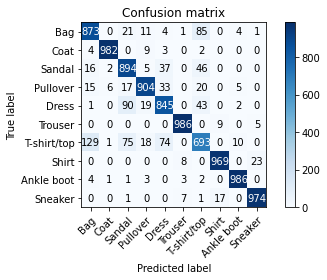

In [145]:
# Pen fremstilling av confusion matrixen
plot_confusion_matrix(testset.targets, train_preds.argmax(dim=1), classes=label_dict,
                      title='Confusion matrix')
plt.show()

In [146]:
print('Accuracy: {:.2f}%'.format(accuracy_score(testset.targets, train_preds.argmax(dim=1), normalize=True)*100))

Accuracy: 91.06%
